In [1]:
import glob
import os
import sys
import smrclib

In [2]:
try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

In [3]:
import carla
import random
import time
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
SECONDS_PER_EPISODE = 12

In [4]:
def xxx():
    for actor in env.actor_list:
        actor.destroy()

In [5]:
def update_q(state,new_state,action,reward):
    global learning_rate,discount_rate,q_table,dist_q
    if state == new_state:
        if state in dist_q  :
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)        
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        else :
            dist_q.append(state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
    else:
        if state in dist_q and new_state in dist_q :
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        elif state in dist_q :
            dist_q.append(new_state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(new_st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        elif new_state in dist_q:
            dist_q.append(state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        else :
            dist_q.append(state)
            dist_q.append(new_state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0])
            q_table.insert(new_st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
            print('NONE')


In [6]:
class CarEnv:
    #BRAKE_AMT = 1.0

    actor_list = []
    collision_hist = []

    pt_cloud = []
    pt_cloud_filtered = []
    
    def __init__(self):
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(2.0)

        self.world = self.client.get_world()

        blueprint_library = self.world.get_blueprint_library()

        self.model_3 = blueprint_library.filter('model3')[0]
        self.truck_2 = blueprint_library.filter('carlamotors')[0]
        
    def reset(self):
        self.collision_hist = []
        self.actor_list = []
        self.pt_cloud = []
        self.pt_cloud_filtered = []
        #place=random.uniform(110,150)
        ##print('Location: ',str(place))
        transform = carla.Transform(carla.Location(-120,125,3),carla.Rotation(0,-90,0))

        self.vehicle = self.world.spawn_actor(self.model_3, transform)
        
        self.actor_list.append(self.vehicle)

        self.lidar_sensor = self.world.get_blueprint_library().find('sensor.lidar.ray_cast')
        self.lidar_sensor.set_attribute('points_per_second', '100000')
        self.lidar_sensor.set_attribute('channels', '32')
        self.lidar_sensor.set_attribute('range', '10000')
        self.lidar_sensor.set_attribute('upper_fov', '10')
        self.lidar_sensor.set_attribute('lower_fov', '-10')
        self.lidar_sensor.set_attribute('rotation_frequency', '60')

        transform = carla.Transform(carla.Location(x=0, z=1.9))
        self.sensor = self.world.spawn_actor(self.lidar_sensor, transform, attach_to=self.vehicle)

        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_lidar(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        self.episode_start = time.time()


        time.sleep(4) # sleep to get things started and to not detect a collision when the car spawns/falls from sky.
        
        transform2 = carla.Transform(carla.Location(x=2.5, z=0.7))
        colsensor = self.world.get_blueprint_library().find('sensor.other.collision')
        self.colsensor = self.world.spawn_actor(colsensor, transform2, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.distance_to_obstacle is None:
            time.sleep(0.01)

        self.episode_start = time.time()

        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        
        return abs(float("%.1f" % self.distance_to_obstacle))

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_lidar(self, raw):
        points = np.frombuffer(raw.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0] / 3), 3))*np.array([1,-1,-1])
        lidar_data = points.astype(np.int32)
        self.pt_cloud.append(lidar_data)

        #screen points specifically -4<y<4 and 0<x<12
        pt = points[np.logical_and(points[:,0] > -3, points[:,0] < 3)]
        points_filter = pt[np.logical_and(pt[:,1] > 0, pt[:,1] < 50)]
        points_filter = points_filter[np.logical_and(points_filter[:,1] > 0, points_filter[:,1] < 50)]
        self.pt_cloud_filtered.append(points_filter)

        if len(points_filter) == 0:
            pass
        else:
            self.distance_to_obstacle = min(points_filter[:,1])-2.247148275375366

    def step(self, action):

        v = self.vehicle.get_velocity()
        kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))
        
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.0))
        elif action == 1:
            while kmh != 0:
                self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=1.0, steer = 0.0))
                ##print(kmh)
                v = self.vehicle.get_velocity()
                kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))
                ##print("distance_to_obstacle = ",self.distance_to_obstacle)
                
        # ถ้ารถชน หรือ รถหยุดแล้ว
        if kmh == 0 or len(self.collision_hist) != 0 :
            done = True
            print('DISTANCE FOR REWARD : ',str(self.distance_to_obstacle))
            if  0<= self.distance_to_obstacle <1 and len(self.collision_hist) != 0 :
                reward = -1
            elif  0<= self.distance_to_obstacle <1:
                reward = 1
            elif  1<= self.distance_to_obstacle <2:
                reward = 1.5
            elif  2<= self.distance_to_obstacle <3:
                reward = 0.45
            elif  3<= self.distance_to_obstacle <4:
                reward = 0.32
            elif  4<= self.distance_to_obstacle <5:
                reward = 0.20
            elif  5<= self.distance_to_obstacle <6:
                reward = -0.15
            elif  6<= self.distance_to_obstacle <7:
                reward = -0.8
            elif  7<= self.distance_to_obstacle <8:
                reward = -1.5
            elif  8<= self.distance_to_obstacle :
                reward = -3
        else:
            done = False
            reward = 0.5
        
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            reward = -1
            dist = 0
            
        dist=abs(float("%.1f" % self.distance_to_obstacle))
            

        return dist,reward, done, None

In [7]:
env = CarEnv()

# action มี 2 อันคือ เบรคและเร่งเต็มที่, state มี 13 อัน คือ ชน, 0-1, 1-2, 2-3, 3-4, 4-5, 5-6, 6-7, 7-8, 8-9, 9-10, 10-11, >11
action_space_size = 2
state_space_size = 10
#q_table = np.zeros((state_space_size, action_space_size))
q_table = []
dist_q=[]

num_episodes = 300
max_steps_per_episode = 100
learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

count = 0
rewards_all_episodes = []
action_all_episodes = []

for episode in range(num_episodes):
    state = env.reset()
      
    ss=time.time()-env.episode_start
    print('LOOP START :'+str(ss))
    done = False
    rewards_current_episode = []
    action_current_episode = []
    count_step=0
    
    for step in range(max_steps_per_episode):
        print(state)
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            #action = np.argmax(q_table[state,:]) 
            #print('YEAH')
            if state not in dist_q:
                break
            action=q_table[dist_q.index(state)].index(max(q_table[dist_q.index(state)][:]))
        else:
            #print('DAMN_BRO')
            action = np.random.randint(0, high=2, size=None, dtype='int')
        action_current_episode.append(action)
        new_state, reward, done, info = env.step(action)
        update_q(state,new_state,action,reward)
        count_step+=1
        state = new_state
        rewards_current_episode.append(reward)
                    
        if done == True:
            print(np.array(q_table))
            #print('destroying actors')
            for actor in env.actor_list:
                actor.destroy()
            count+=1
            print('episode number = ',count)
            #print('distance to obstacle = ',state)
            #print('rewards_current_episode = ',rewards_current_episode)
            print('action_current_episode =', action_current_episode)
            print('count_step = ', count_step)
            break            
        
    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
          (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    #print('exploration rate: '+str(exploration_rate))

    rewards_all_episodes.append(rewards_current_episode)
    action_all_episodes.append(action_current_episode)

LOOP START :0.0
8.8
DISTANCE FOR REWARD :  6.780643701553345
NONE
[[ 0.    0.  ]
 [ 0.   -0.08]]
episode number =  1
action_current_episode = [1]
count_step =  1
LOOP START :0.0
8.8
DISTANCE FOR REWARD :  6.894084215164185
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.    -0.152]]
episode number =  2
action_current_episode = [1]
count_step =  1
LOOP START :0.0
9.1
9.1
DISTANCE FOR REWARD :  6.844031572341919
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.    -0.152]
 [ 0.05  -0.08 ]]
episode number =  3
action_current_episode = [0, 1]
count_step =  2
LOOP START :0.0
8.9
DISTANCE FOR REWARD :  6.796159982681274
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.    -0.152]
 [ 0.    -0.08 ]
 [ 0.05  -0.08 ]]
episode number =  4
action_current_episode = [1]
count_step =  1
LOOP START :0.0
8.9
8.9
8.9
DISTANCE FOR REWARD :  6.80236554145813
[[ 0.       0.     ]
 [ 0.       0.     ]
 [ 0.      -0.152  ]
 [ 0.09995 -0.152  ]
 [ 0.05    -0.08   ]]
episode number =  5
action_current_episode = [0, 0, 1]
count_step =  3
L

LOOP START :0.0
9.0
DISTANCE FOR REWARD :  6.837238550186157
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.14985005 -0.08      ]
 [ 0.3986028  -0.49006361]
 [ 0.34895175 -0.27512   ]
 [ 0.05       -0.3748472 ]
 [ 0.299251   -0.41736248]]
episode number =  27
action_current_episode = [1]
count_step =  1
LOOP START :0.0
9.1
9.1
9.1
DISTANCE FOR REWARD :  6.806950807571411
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.14985005 -0.08      ]
 [ 0.3986028  -0.49006361]
 [ 0.34895175 -0.27512   ]
 [ 0.05       -0.3748472 ]
 [ 0.3986028  -0.45562623]]
episode number =  28
action_current_episode = [0, 0, 1]
count_step =  3
LOOP START :0.0
9.0
9.0
9.0
DISTANCE FOR REWARD :  6.695873498916626
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.14985005 -0.08      ]
 [ 0.3986028  -0.49006361]
 [ 0.34895175

DISTANCE FOR REWARD :  6.888776063919067
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.1997002  -0.152     ]
 [ 1.13743811 -0.70006333]
 [ 0.49775599 -0.3748472 ]
 [ 0.64611426 -0.59665073]
 [ 0.3986028  -0.45562623]
 [ 0.299251   -0.08      ]]
episode number =  47
action_current_episode = [1]
count_step =  1
LOOP START :0.0
9.1
DISTANCE FOR REWARD :  6.679706811904907
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.1997002  -0.152     ]
 [ 1.13743811 -0.70006333]
 [ 0.49775599 -0.3748472 ]
 [ 0.64611426 -0.59665073]
 [ 0.3986028  -0.49006361]
 [ 0.299251   -0.08      ]]
episode number =  48
action_current_episode = [1]
count_step =  1
LOOP START :0.0
9.0
9.0
9.0
9.0
DISTANCE FOR REWARD :  6.681242227554321
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0

LOOP START :0.0
9.0
DISTANCE FOR REWARD :  6.69599461555481
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.1997002  -0.2168    ]
 [ 1.57544621 -0.73443155]
 [ 1.0395662  -0.52105725]
 [ 0.99055676 -0.71246481]
 [ 0.74477268 -0.52105725]
 [ 0.299251   -0.08      ]]
episode number =  66
action_current_episode = [1]
count_step =  1
LOOP START :0.0
9.1
9.1
9.1
9.1
9.1
9.1
9.1
DISTANCE FOR REWARD :  6.731778383255005
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.1997002  -0.2168    ]
 [ 1.57544621 -0.73443155]
 [ 1.0395662  -0.52105725]
 [ 0.99055676 -0.71246481]
 [ 1.0395662  -0.54895152]
 [ 0.299251   -0.08      ]]
episode number =  67
action_current_episode = [0, 0, 0, 0, 0, 0, 1]
count_step =  7
LOOP START :0.0
9.1
DISTANCE FOR REWARD :  6.826342821121216
[[ 0.          0.        ]
 [ 0.          0.    

LOOP START :0.0
9.1
9.1
DISTANCE FOR REWARD :  6.920892000198364
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.3986028  -0.397608  ]
 [ 2.05751845 -0.7522006 ]
 [ 1.13743811 -0.54895152]
 [ 1.33259538 -0.74256816]
 [ 1.33259538 -0.67992429]
 [ 0.299251   -0.08      ]
 [ 0.         -0.08      ]]
episode number =  85
action_current_episode = [0, 1]
count_step =  2
LOOP START :0.0
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
DISTANCE FOR REWARD :  6.650843858718872
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.3986028  -0.397608  ]
 [ 2.62967454 -0.75698054]
 [ 1.13743811 -0.54895152]
 [ 1.33259538 -0.74256816]
 [ 1.33259538 -0.67992429]
 [ 0.299251   -0.08      ]
 [ 0.         -0.08      ]]
episode number =  86
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  13
LOOP

LOOP START :0.0
9.1
9.1
DISTANCE FOR REWARD :  6.756004571914673
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.3986028  -0.397608  ]
 [ 2.77164346 -0.76515424]
 [ 2.05751845 -0.63528709]
 [ 2.15335547 -0.76947837]
 [ 1.72057465 -0.70273868]
 [ 0.44820419 -0.152     ]
 [ 0.         -0.08      ]]
episode number =  101
action_current_episode = [0, 1]
count_step =  2
LOOP START :0.0
8.7
8.7
8.7
8.7
DISTANCE FOR REWARD :  6.802884340286255
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.54725823 -0.4378472 ]
 [ 2.77164346 -0.76515424]
 [ 2.05751845 -0.63528709]
 [ 2.15335547 -0.76947837]
 [ 1.72057465 -0.70273868]
 [ 0.44820419 -0.152     ]
 [ 0.         -0.08      ]]
episode number =  102
action_curre

LOOP START :0.0
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
DISTANCE FOR REWARD :  6.876788377761841
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.59671098 -0.47406248]
 [ 2.91318689 -0.77177493]
 [ 2.24900091 -0.70273868]
 [ 2.43971859 -0.77527748]
 [ 2.77164346 -0.74256816]
 [ 0.44820419 -0.152     ]
 [ 0.         -0.08      ]]
episode number =  117
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 1]
count_step =  8
LOOP START :0.0
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
DISTANCE FOR REWARD :  6.745319604873657
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.59671098 -0.47406248]
 [ 2.91318689 -0.77177493]
 [ 2.24900091 -0.70273868]
 [ 2.43971859 -0.77527748

LOOP START :0.0
8.9
DISTANCE FOR REWARD :  6.82911229133606
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.59671098 -0.47406248]
 [ 4.44244487 -0.77942393]
 [ 2.91318689 -0.72121833]
 [ 3.00731343 -0.77774973]
 [ 5.92203651 -0.77527748]
 [ 0.44820419 -0.152     ]
 [ 0.         -0.08      ]]
episode number =  131
action_current_episode = [1]
count_step =  1
LOOP START :0.0
8.8
8.8
8.8
8.8
8.8
8.8
DISTANCE FOR REWARD :  6.7936012744903564
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.59671098 -0.47406248]
 [ 4.66977753 -0.78148153]
 [ 2.91318689 -0.72121833]
 [ 3.00731343 -0.77774973]
 [ 5.92203651 -0.77527748]
 [ 0.44820419 -0.152     ]
 [ 0.  

LOOP START :0.0009996891021728516
8.9
8.9
DISTANCE FOR REWARD :  6.762331247329712
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.59671098 -0.47406248]
 [ 5.12104532 -0.78650004]
 [ 5.43425712 -0.75813219]
 [ 4.89597579 -0.78197728]
 [ 6.09808408 -0.77997476]
 [ 0.44820419 -0.152     ]
 [ 0.         -0.08      ]]
episode number =  145
action_current_episode = [0, 1]
count_step =  2
LOOP START :0.0
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
DISTANCE FOR REWARD :  6.824195146560669
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.59671098 -0.47406248]
 [ 5.12104532 -0.78650004]
 [ 6.22965816 -0.76231897]
 [ 4.895975

LOOP START :0.0
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
DISTANCE FOR REWARD :  6.781819581985474
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.59671098 -0.47406248]
 [ 7.01086303 -0.79015853]
 [ 7.56638093 -0.76947837]
 [ 5.47882286 -0.7854016 ]
 [ 8.11472026 -0.78935776]
 [ 0.44820419 -0.152     ]
 [ 0.         -0.08      ]]
episode number =  159
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  21
LOOP START :0.0
8.7
8.7
DISTANCE FOR REWARD :  6.85175347328186
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.64611426 -0.50665623]
 [ 7.01086303 -0.7

LOOP START :0.0
9.1
9.1
9.1
9.1
9.1
DISTANCE FOR REWARD :  6.8840858936309814
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 2.91318689 -0.53599061]
 [ 7.60881455 -0.79114267]
 [ 8.8622809  -0.77774973]
 [ 7.56638093 -0.74303699]
 [ 9.06755853 -0.79224181]
 [ 0.44820419 -0.152     ]
 [ 0.         -0.08      ]]
episode number =  172
action_current_episode = [0, 0, 0, 0, 1]
count_step =  5
LOOP START :0.0
8.9
8.9
DISTANCE FOR REWARD :  6.616597414016724
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 2.91318689 -0.53599061]
 [ 7.60881455 -0.7911

DISTANCE FOR REWARD :  6.784411668777466
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 2.91318689 -0.53599061]
 [ 9.06755853 -0.79418871]
 [ 8.90341862 -0.77997476]
 [ 7.82034699 -0.74873329]
 [10.23812936 -0.79587698]
 [ 0.54725823 -0.2168    ]
 [ 0.         -0.08      ]]
episode number =  185
action_current_episode = [0, 0, 0, 0, 1]
count_step =  5
LOOP START :0.0
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
DISTANCE FOR REWARD :  6.810223817825317
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.   

LOOP START :0.0
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
DISTANCE FOR REWARD :  6.140136957168579
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 4.57898091 -0.58615239]
 [10.15848617 -0.79576357]
 [ 9.71758854 -0.78377955]
 [ 8.61458838 -0.76636391]
 [12.70436082 -0.79666035]
 [ 0.54725823 -0.2168    ]
 [ 0.         -0.08      ]]
episode number =  198
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  38
LOOP START :0.0
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
DISTANCE FOR REWARD :  6.799811601638794
[[ 0.          0.        ]
 [ 0

LOOP START :0.0
9.0
9.0
9.0
DISTANCE FOR REWARD :  6.812133073806763
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 4.57898091 -0.58615239]
 [10.15848617 -0.79576357]
 [11.3365612  -0.78935776]
 [ 9.51557084 -0.77793136]
 [15.29650565 -0.79780886]
 [ 0.54725823 -0.2168    ]
 [ 0.         -0.08      ]]
episode number =  210
action_current_episode = [0, 0, 1]
count_step =  3
LOOP START :0.0
8.9
8.9
DISTANCE FOR REWARD :  6.840157747268677
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 4.5789

LOOP START :0.0
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
DISTANCE FOR REWARD :  6.699761629104614
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 4.57898091 -0.58615239]
 [14.52417811 -0.79774859]
 [12.14042528 -0.79224181]
 [ 9.51557084 -0.77793136]
 [16.92372137 -0.79840266]
 [ 0.54725823 -0.2168    ]
 [ 0.         -0.08      ]]
episode number =  222
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  19
LOOP START :0.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
DISTANCE FOR REWARD :  6.765167474746704
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          

LOOP START :0.0
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
8.9
DISTANCE FOR REWARD :  6.756723642349243
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 5.92203651 -0.62678344]
 [15.01762419 -0.79797373]
 [17.28574669 -0.79541887]
 [11.72146036 -0.78391196]
 [17.18740732 -0.79856239]
 [ 0.54725823 -0.2168    ]
 [ 0.         -0.08      ]]
episode number =  234
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  51
LOOP START :0.0
8.8
8.8
8.8
8.8
8.

DISTANCE FOR REWARD :  6.661620378494263
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 6.09808408 -0.64410509]
 [17.25299969 -0.79867056]
 [19.86251226 -0.79666035]
 [12.55480456 -0.78696869]
 [17.579      -0.79870615]
 [ 0.54725823 -0.2168    ]
 [ 0.         -0.08      ]]
episode number =  245
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  69
LOOP START :0.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0


LOOP START :0.0
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
DISTANCE FOR REWARD :  6.830651521682739
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 6.09808408 -0.64410509]
 [18.78847716 -0.79903084]
 [21.81651088 -0.79699432]
 [15.88176889 -0.79230514]
 [17.93385318 -0.79895198]
 [ 0.54725823 -0.2168    ]
 [ 0.         -0.08      ]]
episode number =  256
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  36
LOOP START :0.0
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
DISTANCE FOR REWARD :  6.75556492805481
[[ 0.          0.        ]
 [ 0.          0

LOOP START :0.0
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
9.1
DISTANCE FOR REWARD :  6.672162294387817
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 6.09808408 -0.64410509]
 [19.68105276 -0.79936413]
 [21.92907585 -0.79729489]
 [17.48154215 -0.79376716]
 [19.28413357 -0.79938116]
 [ 0.54725823 -0.2168    ]
 [ 0.         -0.08      ]]
episode number =  268
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  14
LOOP START :0.0
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
8.8
DISTANCE FOR REWARD :  6.748387575149536
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        

LOOP START :0.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
DISTANCE FOR REWARD :  2.1858465671539307
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 5.79198599 -0.64410509]
 [23.05726199 -0.79942772]
 [24.32058282 -0.7975654 ]
 [20.34111239 -0.37251957]
 [20.45957011 -0.79949874]
 [ 0.54725823 -0.2168    ]
 [ 0.         -0.08      ]]
episode number =  278
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  11
LOOP START :0.0
8.9
8.9
8.9
DISTANCE FOR REWARD :  2.1368157863616943
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]


LOOP START :0.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
LOOP START :0.0
7.2
LOOP START :0.0
8.5
LOOP START :0.0
6.9
DISTANCE FOR REWARD :  6.872177362442017
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.08        0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 5.79198599 -0.64410509]
 [23.64381975 -0.67448495]
 [27.20297047 -0.2866748

RuntimeError: Spawn failed because of collision at spawn position

In [210]:
state

11.6

In [200]:
q_table[dist_q.index(state)].index(max(q_table[dist_q.index(state)][:]))

0

In [8]:
xxx()


In [9]:
print(np.array(q_table))
print(np.array(dist_q))

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.08        0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 5.79198599 -0.64410509]
 [23.64381975 -0.67448495]
 [27.20297047 -0.28667489]
 [23.45156202 -0.29026762]
 [20.75364862 -0.56209398]
 [ 0.54725823 -0.2168    ]
 [ 0.         -0.08      ]]
[2.  2.1 2.2 2.3 6.  6.1 6.2 6.3 6.5 6.6 6.7 6.8 6.9 7.  7.1 8.7 8.8 8.9
 9.  9.1 9.2 9.3]


10 : -0.3999999999999999
20 : -0.7499999999999998
30 : -0.9199999999999999
40 : -0.9700000000000006
50 : -0.7200000000000008
60 : -0.4200000000000007
70 : -0.12000000000000058
80 : -0.39000000000000046
90 : 0.4599999999999995
100 : 1.5599999999999992
110 : 2.209999999999998
120 : 4.3599999999999985
130 : 7.560000000000002
140 : 11.410000000000005
150 : 14.610000000000003
160 : 18.55999999999999
170 : 23.42499999999998
180 : 27.274999999999967
190 : 30.024999999999956
200 : 37.87499999999994
210 : 41.47499999999993
220 : 48.87499999999992
230 : 55.22499999999995
240 : 63.375
250 : 72.97500000000005
260 : 81.1750000000001
270 : 86.07500000000013
280 : 101.74000000000017
290 : 115.7000000000002


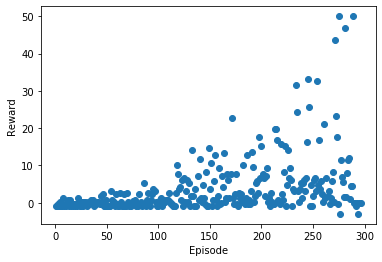

In [10]:
a=rewards_all_episodes
n = 0 
count = 0
n_list=[]
count_list=[]
for i in a :
    for j in i:
        count += j
    count_list.append(sum(i))
    n+=1
    n_list.append(n)
    if n%10 == 0:
        print(n,':',str(count/10)) 
        
ax=plt.scatter(n_list,count_list,marker='o')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [11]:
b=action_all_episodes
step = []
episode=[]
n=1
for i in b:
    step.append(len(i))
    episode.append(n)
    n+=1
print(step)
print(episode)

[1, 1, 2, 1, 3, 1, 1, 5, 1, 2, 1, 4, 1, 4, 1, 2, 1, 2, 1, 2, 1, 5, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 2, 3, 4, 3, 4, 1, 2, 2, 3, 3, 2, 6, 3, 7, 1, 1, 4, 1, 1, 1, 1, 9, 4, 3, 3, 1, 7, 2, 1, 1, 8, 3, 1, 1, 7, 1, 1, 8, 3, 1, 2, 1, 5, 2, 4, 1, 2, 1, 7, 2, 3, 1, 2, 13, 2, 1, 4, 8, 3, 1, 4, 7, 10, 9, 9, 3, 1, 1, 2, 4, 5, 1, 4, 3, 4, 4, 4, 8, 3, 2, 2, 1, 1, 1, 8, 23, 18, 10, 11, 4, 15, 1, 16, 3, 9, 15, 3, 13, 1, 6, 31, 6, 1, 10, 1, 17, 4, 26, 5, 3, 12, 5, 2, 19, 1, 1, 32, 10, 24, 1, 4, 14, 28, 4, 1, 6, 21, 2, 1, 17, 11, 29, 3, 5, 18, 15, 5, 18, 48, 5, 2, 7, 18, 2, 1, 8, 5, 7, 3, 23, 3, 2, 5, 28, 2, 4, 2, 9, 30, 22, 3, 6, 13, 14, 8, 38, 16, 33, 18, 16, 6, 17, 21, 3, 5, 1, 8, 3, 2, 2, 42, 42, 36, 4, 3, 2, 34, 7, 4, 19, 33, 1, 12, 31, 16, 21, 15, 1, 10, 9, 66, 51, 9, 3, 10, 13, 5, 13, 15, 9, 16, 35, 69, 54, 1, 12, 1, 6, 15, 16, 9, 68, 12, 36, 10, 14, 7, 3, 45, 5, 16, 6, 9, 2, 5, 14, 19, 3, 90, 49, 38, 2, 100, 1, 21, 14, 11, 3, 94, 3, 16, 23, 24, 2, 9, 9, 100, 0, 0, 1, 0, 1, 0, 0]
[1, 2, 3, 4, 5, 6, 7

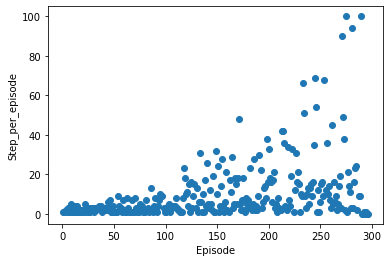

In [12]:
ax=plt.scatter(episode,step,marker='o')
plt.xlabel('Episode')
plt.ylabel('Step_per_episode')
plt.show()

In [67]:
q_table

array([[ 0.349251  ,  0.20832748],
       [ 1.77224689, -0.73807624],
       [ 0.99055676, -0.59842658],
       [ 0.        ,  0.        ],
       [ 0.        , -0.06542415],
       [27.15730793, -0.6529352 ],
       [34.00748832, -0.65424151],
       [ 1.71618289,  0.06933105],
       [49.99300531,  1.96897879],
       [49.37267201,  0.27837086]])

In [15]:
import random
random.uniform(110,150)


133.38019801314636

In [27]:
index_q

[0.1, 0.2, 0.3, 0.4, 0.5]

In [20]:
x

0.1